# Divide a parcelle in plots

In [19]:
import warnings

warnings.simplefilter(action="ignore")

import functools
import argparse
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import gamma
import os
import time
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchnet as tnt
from sklearn.neighbors import NearestNeighbors

import gc

# from osgeo import gdal, osr  # TODO: UNCOMMENT
import torch.nn as nn
from scipy.special import digamma, polygamma

import matplotlib

# Weird behavior: loading twice in cell appears to remove an elsewise occuring error.
for i in range(2):
    try:
        matplotlib.use("TkAgg")  # rerun this cell if an error occurs.
    except:
        print("!")
import matplotlib.pyplot as plt


import pickle
from torch_scatter import scatter_max, scatter_mean

print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()

# We import from other files
import sys
sys.path.append("/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/")
from config import args
from model.model import PointNet
from utils.useful_functions import *
from data_loader.loader import *
from utils.load_las_data import *
from model.loss_functions import *
from model.accuracy import *
from em_gamma.get_gamma_parameters_em import *
from model.train import train_full

print("Everything is imported")


print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()

False
Everything is imported
False


## Loading single parcelle file

In [6]:
import seaborn as sns; sns.set();
from math import cos, pi, ceil
import pandas as pd
import json

In [7]:
# Create the result folder
create_new_experiment_folder(args)  # new paths are added to args
las_folder = args.las_parcelles_folder_path
centers_dict_path = os.path.join(args.stats_path, "parcelles_division_centers.json")
centers_dict = {}

13:02:15
Results folder:  /home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/DEV/2021-06-02_15h02m15s/


In [14]:
las_filename = "004000715-5-18.las" # numero un
# las_filename = "004010636-29-1.las"  # numero deux

In [15]:
points_nparray, xy_averages = load_single_las(las_folder, las_filename)
x_las, y_las = points_nparray[:,0], points_nparray[:,1]
# subsample = False
# if subsample:
#     subsampling = 500
#     subset = np.random.choice(points_nparray.shape[0],size=subsampling, replace=False)
#     x_las = x_las[subset]
#     y_las = y_las[subset]
x_min = x_las.min()
y_min = y_las.min()
x_max = x_las.max()
y_max = y_las.max()
print("ranges x y: ",x_max-x_min, y_max-y_min)

ranges x y:  78.35999999998603 94.37999999988824


In [16]:
# 1) Identify centers of plots whose squares cover at least partially every pixel of the parcelle
# We consider the square included in a plot with r=10m. Formula for width of 
# the square is  W = 2 * (cos(45°) * r) since max radius in square equals r as well.
# We add an overlap of s*0.625 i.e. a pixel in currently produced plots of size 32 pix = 10

plot_radius_meters = 10
cos_of_45_degrees = cos(pi/4)
within_circle_square_width_meters = 2 * cos_of_45_degrees * plot_radius_meters
plot_diameter_in_pixels = args.diam_pix  # 32 by default
plot_diameter_in_meters = 20  # 2 * 10m
s = 5
square_xy_overlap = s * plot_diameter_in_meters/plot_diameter_in_pixels  # 0.625 by default
movement_in_meters = within_circle_square_width_meters - square_xy_overlap

print(f"Square dimensions are {within_circle_square_width_meters}m*{within_circle_square_width_meters}m" +
      f"but we move {movement_in_meters}m at a time to have {square_xy_overlap}m of overlap")

x_range_of_parcelle_in_movements = ceil((x_max - x_min)/(movement_in_meters)) +1 # should it be +1 here ??
y_range_of_parcelle_in_movements = ceil((y_max - y_min)/(movement_in_meters)) +1
# print(x_range_of_parcelle_in_movements, y_range_of_parcelle_in_movements)

start_x = x_min + movement_in_meters/4
start_y = y_min + movement_in_meters/4
grid_pixel_xy_centers = [[start_x, start_y]]

for i_dx in range(x_range_of_parcelle_in_movements):
    current_x = start_x + i_dx * movement_in_meters  # move along x axis
    for i_dy in range(y_range_of_parcelle_in_movements):
        current_y = start_y + i_dy * movement_in_meters  # move along y axis
        new_plot_center = [current_x, current_y]
        grid_pixel_xy_centers.append(new_plot_center)

centers_dict[las_filename] = grid_pixel_xy_centers

Square dimensions are 14.142135623730951m*14.142135623730951mbut we move 11.017135623730951m at a time to have 3.125m of overlap


In [17]:
# Saving the centers
with open(centers_dict_path, 'w') as outfile:
    json.dump(centers_dict, outfile)

# Visualize the cutting of the parcelle

<IPython.core.display.Javascript object>


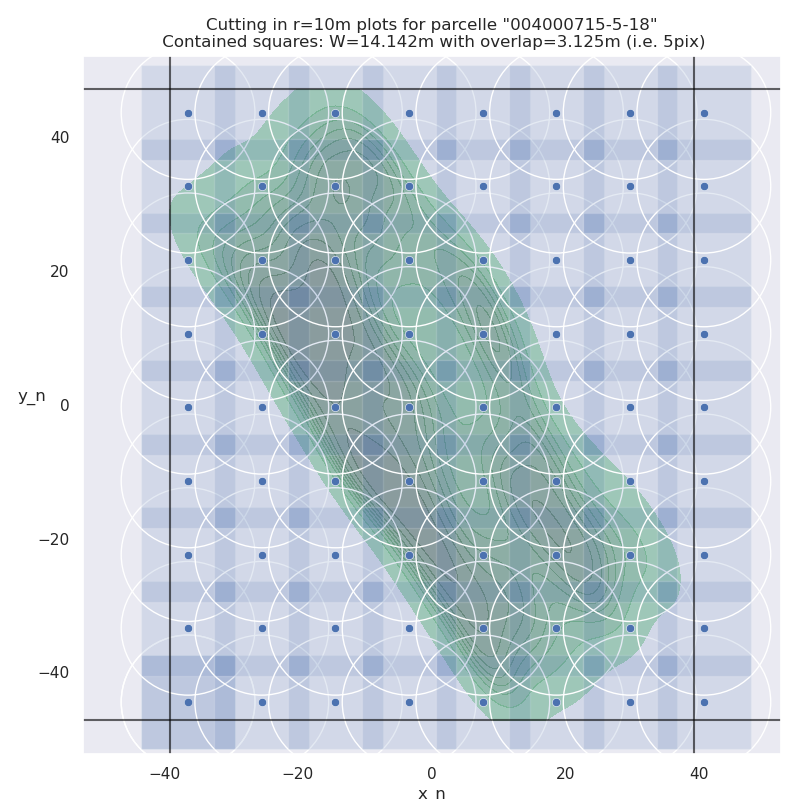

In [32]:
%matplotlib notebook
parcelle_id = las_filename.split('.')[0]
cutting_plot_save_path = os.path.join(args.stats_path, f"img/cuttings/{parcelle_id}")
sampling_size_for_kde = 3000


create_dir(cutting_plot_save_path)



# we need to normalize coordinates points for easier visualization
x_center = (x_min + x_max)/2
y_center = (y_min + y_max)/2
x_min_c = x_min - x_center
x_max_c = x_max - x_center
y_min_c = y_min - y_center
y_max_c = y_max - y_center

# xy to dataframe for visualization
coordinates = np.array(np.stack([x_las-x_center,y_las-y_center],axis=1))
coordinates = pd.DataFrame(data = coordinates)
coordinates.columns = ["x_n","y_n"]
if len(coordinates)>sampling_size_for_kde:
    coordinates = coordinates.sample(n=sampling_size_for_kde, replace=False)
    
# centers to dataframe for visualization
centers = np.array(grid_pixel_xy_centers - np.array([x_center, y_center]))
centers = pd.DataFrame(data = centers)
centers.columns = ["x_n","y_n"]

# Sanity check visualizing the position of centers
fig, ax = plt.subplots(figsize = (8,8), subplot_kw={"aspect":"equal"})
ax.grid(False)
ax.set_aspect('equal')  # Not working right now
plt.xlim(min(x_min_c, y_min_c)-5, max(x_max_c, y_max_c)+5)
plt.ylim(min(x_min_c, y_min_c)-5, max(x_max_c, y_max_c)+5)
plt.ylabel('y_n',rotation=0)
plt.title(f"Cutting in r=10m plots for parcelle \"{parcelle_id}\"" +
f"\n Contained squares: W={np.round(within_circle_square_width_meters,3)}m with overlap={np.round(square_xy_overlap,3)}m (i.e. {s}pix)")

fig.tight_layout()
sns.kdeplot(data = coordinates, x="x_n", y="y_n", fill=True, 
            alpha=0.5, color="g", 
            clip = [[x_min_c, x_max_c], [y_min_c, y_max_c]])  #thresh=0.2
sns.scatterplot(data = centers, x="x_n", y="y_n")

for row_idx, (x, y) in centers.iterrows():
    a_circle = plt.Circle((x, y), 10, fill=False)
    ax.add_patch(a_circle)
    a_square = matplotlib.patches.Rectangle((x-within_circle_square_width_meters/2, 
                                             y-within_circle_square_width_meters/2), 
                                            within_circle_square_width_meters,
                                            within_circle_square_width_meters,
                                            fill=True, alpha =0.15)
    ax.add_patch(a_square)
    
plt.axhline(y=y_min_c, xmin=x_min_c, xmax=x_max_c, color='black', alpha = 0.6, linestyle='-')
plt.axhline(y=y_max_c, xmin=x_min_c, xmax=x_max_c, color='black', alpha = 0.6, linestyle='-')
plt.axvline(x=x_min_c, ymin=y_min_c, ymax=y_max_c, color='black', alpha = 0.6, linestyle='-')
plt.axvline(x=x_max_c, ymin=y_min_c, ymax=y_max_c, color='black', alpha = 0.6, linestyle='-')
fig.show()
plt.savefig(cutting_plot_save_path)

# OTHER

In [18]:
# Define a transformation, that takes parcelles data (np array of points) and a center, and outputs the 
# pseudo placettes data

# Then load the model, and produce an inference by running PCC

{'004000715-5-18.las': [[911578.494283906, 6316567.424283906],
  [911578.494283906, 6316567.424283906],
  [911578.494283906, 6316578.44141953],
  [911578.494283906, 6316589.458555154],
  [911578.494283906, 6316600.475690777],
  [911578.494283906, 6316611.492826401],
  [911578.494283906, 6316622.509962024],
  [911578.494283906, 6316633.527097648],
  [911578.494283906, 6316644.544233272],
  [911578.494283906, 6316655.561368896],
  [911578.494283906, 6316666.57850452],
  [911589.5114195297, 6316567.424283906],
  [911589.5114195297, 6316578.44141953],
  [911589.5114195297, 6316589.458555154],
  [911589.5114195297, 6316600.475690777],
  [911589.5114195297, 6316611.492826401],
  [911589.5114195297, 6316622.509962024],
  [911589.5114195297, 6316633.527097648],
  [911589.5114195297, 6316644.544233272],
  [911589.5114195297, 6316655.561368896],
  [911589.5114195297, 6316666.57850452],
  [911600.5285551534, 6316567.424283906],
  [911600.5285551534, 6316578.44141953],
  [911600.5285551534, 631658